In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Load and preprocess dataset
def load_and_preprocess_dataset(base_dir):
    images = []
    labels = []
    label_map = {'infected': 1, 'notinfected': 0}  # Define label mapping

    for label in label_map.keys():
        class_dir = os.path.join(base_dir, label)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    img_path = os.path.join(class_dir, filename)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ensure RGB format
                        img = cv2.resize(img, (224, 224))  # Resize to 224x224
                        images.append(img)
                        labels.append(label_map[label])

    images = np.array(images)
    labels = np.array(labels)

    return images, labels, label_map

In [2]:
def preprocess_images(images):
    preprocessed_images = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    for img in images:
        if len(img.shape) == 3 and img.shape[2] == 3:  # if it's a color image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       
        img_clahe = clahe.apply(img)
        img_resized = cv2.resize(img_clahe, (224, 224))
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)
        img_preprocessed = preprocess_input(img_resized)
        preprocessed_images.append(img_preprocessed)
   
    return np.array(preprocessed_images)


In [3]:
# Load the dataset
base_dir = 'data'
images, labels, label_map = load_and_preprocess_dataset(base_dir)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Preprocess images
X_train = preprocess_images(X_train)
X_val = preprocess_images(X_val)
X_test = preprocess_images(X_test)

# Create ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to the training data
datagen.fit(X_train)


In [5]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=10,
                    validation_data=(X_val, y_val))


Epoch 1/10
47/47 [==============================] - 57s 1s/step - loss: 23.9357 - accuracy: 0.5831 - val_loss: 0.6922 - val_accuracy: 0.5833
Epoch 2/10
47/47 [==============================] - 54s 1s/step - loss: 0.6742 - accuracy: 0.6108 - val_loss: 0.5896 - val_accuracy: 0.7760
Epoch 3/10
47/47 [==============================] - 54s 1s/step - loss: 0.5463 - accuracy: 0.7951 - val_loss: 0.5206 - val_accuracy: 0.8229
Epoch 4/10
47/47 [==============================] - 55s 1s/step - loss: 0.5112 - accuracy: 0.8230 - val_loss: 0.4944 - val_accuracy: 0.8229
Epoch 5/10
47/47 [==============================] - 55s 1s/step - loss: 0.5022 - accuracy: 0.8090 - val_loss: 0.4613 - val_accuracy: 0.8125
Epoch 6/10
47/47 [==============================] - 55s 1s/step - loss: 0.4755 - accuracy: 0.8285 - val_loss: 0.4207 - val_accuracy: 0.8281
Epoch 7/10
47/47 [==============================] - 55s 1s/step - loss: 0.4816 - accuracy: 0.8197 - val_loss: 0.3909 - val_accuracy: 0.8385
Epoch 8/10
47/47 [=

6/6 [==============================] - 1s 229ms/step - loss: 0.3395 - accuracy: 0.8594
Test accuracy: 0.859375


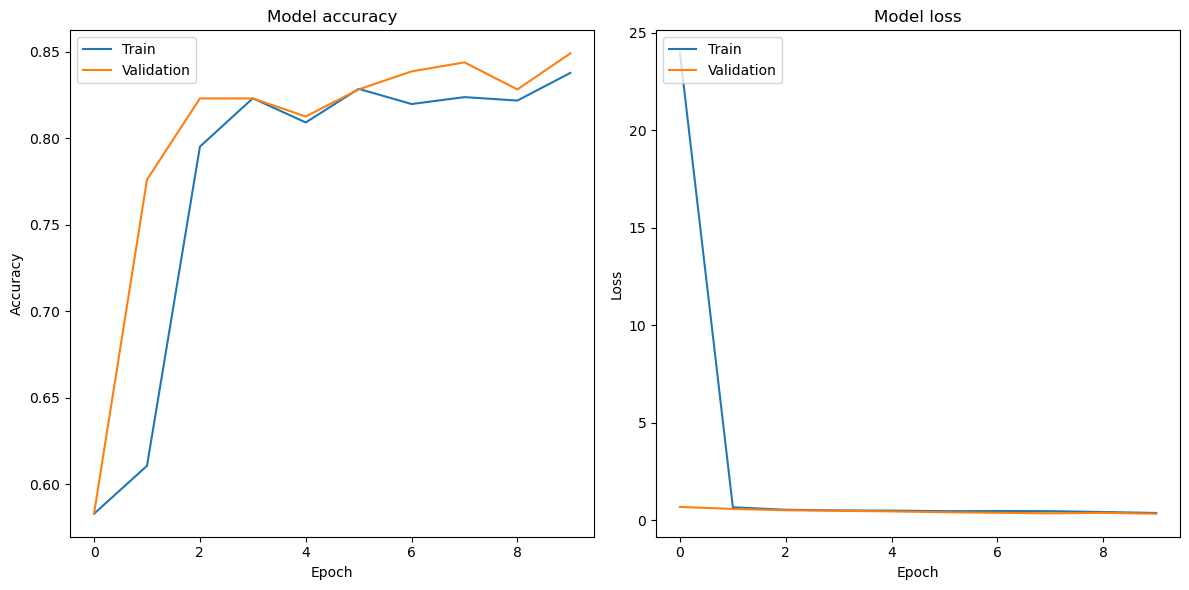

In [6]:
# Evaluate the model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [10]:
# Plot confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

6/6 [==============================] - 1s 228ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets